# Utility Metrics Evaluation

**Goal:** Show that Fisher unlearning preserves retain-set utility

**Comparisons:**
- Baseline: Original VAE (no unlearning)
- Fisher: Fisher unlearning on structured forget set
- Retrain: Gold standard retrain on D\F

**Metrics:**
1. kNN-overlap in latent space (k=50)
2. PBMC marker gene separability (6 canonical markers)
3. Latent space quality (silhouette score)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import scanpy as sc
import json
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, silhouette_score

import sys
sys.path.append('src')
from vae import VAE

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 4)

print("Utility Metrics Evaluation")

## 1. Load Data and Models

In [2]:
# Paths
data_path = 'data/adata_processed.h5ad'
split_path = 'outputs/p1/split_structured.json'
baseline_path = 'outputs/p1/baseline_v2/best_model.pt'
fisher_path = 'outputs/p2/fisher_unlearn_structured_CORRECTED/unlearned_model.pt'  # CORRECTED: Fisher on retain set
retrain_path = 'outputs/p1/retrain_structured_v2/best_model.pt'  # Updated to use v2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


In [3]:
# Load data
adata = sc.read_h5ad(data_path)
print(f"Data shape: {adata.shape}")

with open(split_path, 'r') as f:
    split = json.load(f)

retain_idx = np.array(split['retain_indices'])
forget_idx = np.array(split['forget_indices'])

print(f"Retain set: {len(retain_idx)} cells")
print(f"Forget set: {len(forget_idx)} cells")

Data shape: (33088, 2000)


Retain set: 28094 cells
Forget set: 30 cells


In [4]:
# Load baseline first to get config
baseline_checkpoint = torch.load(baseline_path, map_location=device)
baseline_config = baseline_checkpoint['config']

# Helper function to load models
def load_model_with_config(checkpoint_path, reference_config, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Use reference config (from baseline) since all models have same architecture
    # Don't override with checkpoint config which may be incomplete
    state_dict = checkpoint['model_state_dict']
    has_batchnorm = any('running_mean' in k or 'running_var' in k for k in state_dict.keys())
    actual_use_layer_norm = not has_batchnorm
    
    model = VAE(
        input_dim=reference_config['input_dim'],
        hidden_dims=reference_config['hidden_dims'],
        latent_dim=reference_config['latent_dim'],
        likelihood=reference_config.get('likelihood', 'nb'),
        use_layer_norm=actual_use_layer_norm
    ).to(device)
    
    model.load_state_dict(state_dict)
    model.eval()
    
    return model

# Load all models using baseline config as reference
print("Loading models...")
baseline_model = load_model_with_config(baseline_path, baseline_config, device)
fisher_model = load_model_with_config(fisher_path, baseline_config, device)
retrain_model = load_model_with_config(retrain_path, baseline_config, device)
print("✓ Models loaded")

Loading models...


✓ Models loaded


## 2. Extract Latent Embeddings

In [5]:
def get_latent_embeddings(model, adata, indices, device, batch_size=256):
    """Extract latent embeddings for specified cells."""
    model.eval()
    embeddings = []
    
    with torch.no_grad():
        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i+batch_size]
            x_batch = torch.FloatTensor(
                adata.X[batch_indices].toarray() if hasattr(adata.X, 'toarray') 
                else adata.X[batch_indices]
            ).to(device)
            
            mu, logvar = model.encode(x_batch)
            embeddings.append(mu.cpu().numpy())
    
    return np.vstack(embeddings)

# Extract embeddings for retain set
print("Extracting latent embeddings...")
baseline_z = get_latent_embeddings(baseline_model, adata, retain_idx, device)
fisher_z = get_latent_embeddings(fisher_model, adata, retain_idx, device)
retrain_z = get_latent_embeddings(retrain_model, adata, retain_idx, device)

print(f"Embedding shape: {baseline_z.shape}")
print(f"Latent dim: {baseline_z.shape[1]}")

Extracting latent embeddings...


Embedding shape: (28094, 32)
Latent dim: 32


## 3. kNN-Overlap Analysis

In [6]:
def compute_knn_overlap(embeddings1, embeddings2, k=50):
    """Compute k-NN overlap between two embedding spaces."""
    n_cells = embeddings1.shape[0]
    
    # Find k-NN in both spaces
    nn1 = NearestNeighbors(n_neighbors=k+1, metric='euclidean').fit(embeddings1)
    nn2 = NearestNeighbors(n_neighbors=k+1, metric='euclidean').fit(embeddings2)
    
    neighbors1 = nn1.kneighbors(embeddings1, return_distance=False)[:, 1:]  # Exclude self
    neighbors2 = nn2.kneighbors(embeddings2, return_distance=False)[:, 1:]
    
    # Compute Jaccard similarity for each cell
    overlaps = []
    for i in range(n_cells):
        set1 = set(neighbors1[i])
        set2 = set(neighbors2[i])
        jaccard = len(set1 & set2) / len(set1 | set2)
        overlaps.append(jaccard)
    
    return np.array(overlaps)

# Compute overlaps
print("Computing kNN-overlap (k=50)...")
overlap_fisher_baseline = compute_knn_overlap(fisher_z, baseline_z, k=50)
overlap_fisher_retrain = compute_knn_overlap(fisher_z, retrain_z, k=50)
overlap_baseline_retrain = compute_knn_overlap(baseline_z, retrain_z, k=50)

print(f"Fisher vs Baseline:  {overlap_fisher_baseline.mean():.4f} ± {overlap_fisher_baseline.std():.4f}")
print(f"Fisher vs Retrain:   {overlap_fisher_retrain.mean():.4f} ± {overlap_fisher_retrain.std():.4f}")
print(f"Baseline vs Retrain: {overlap_baseline_retrain.mean():.4f} ± {overlap_baseline_retrain.std():.4f}")

Computing kNN-overlap (k=50)...


/Users/dbenson/.pyenv/versions/stat4243/lib/python3.12/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Fisher vs Baseline:  0.1699 ± 0.0856
Fisher vs Retrain:   0.1189 ± 0.0772
Baseline vs Retrain: 0.2161 ± 0.0981


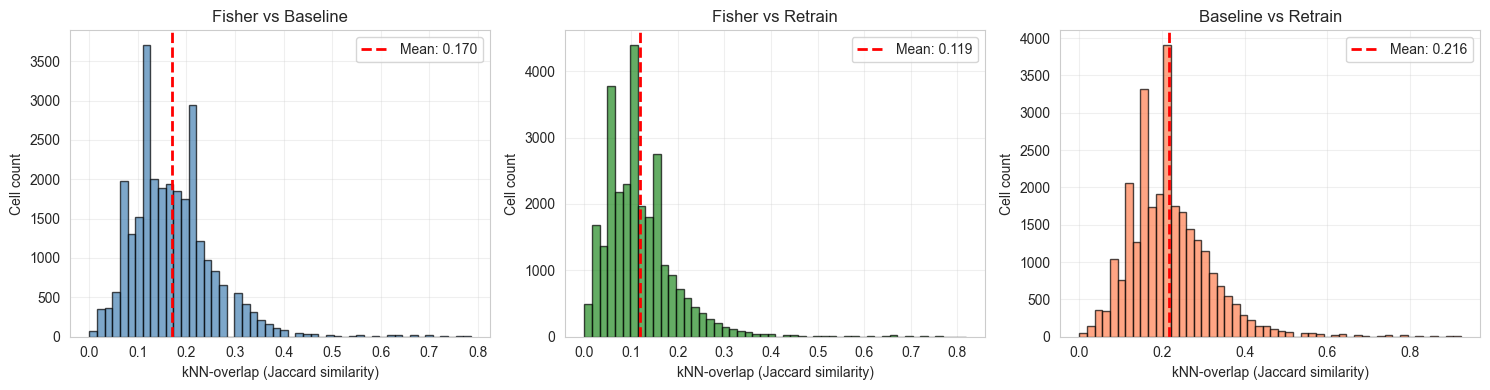

✓ kNN-overlap plot saved to outputs/p2/utility_knn_overlap.png


In [7]:
# Visualize kNN-overlap distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Fisher vs Baseline
axes[0].hist(overlap_fisher_baseline, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(overlap_fisher_baseline.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {overlap_fisher_baseline.mean():.3f}')
axes[0].set_xlabel('kNN-overlap (Jaccard similarity)')
axes[0].set_ylabel('Cell count')
axes[0].set_title('Fisher vs Baseline')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Fisher vs Retrain
axes[1].hist(overlap_fisher_retrain, bins=50, alpha=0.7, color='forestgreen', edgecolor='black')
axes[1].axvline(overlap_fisher_retrain.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {overlap_fisher_retrain.mean():.3f}')
axes[1].set_xlabel('kNN-overlap (Jaccard similarity)')
axes[1].set_ylabel('Cell count')
axes[1].set_title('Fisher vs Retrain')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Baseline vs Retrain
axes[2].hist(overlap_baseline_retrain, bins=50, alpha=0.7, color='coral', edgecolor='black')
axes[2].axvline(overlap_baseline_retrain.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {overlap_baseline_retrain.mean():.3f}')
axes[2].set_xlabel('kNN-overlap (Jaccard similarity)')
axes[2].set_ylabel('Cell count')
axes[2].set_title('Baseline vs Retrain')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/p2/utility_knn_overlap.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ kNN-overlap plot saved to outputs/p2/utility_knn_overlap.png")

## 4. PBMC Marker Gene Separability

In [8]:
# PBMC canonical markers
PBMC_MARKERS = {
    'T_cells': ['CD3D', 'CD3E'],
    'B_cells': ['MS4A1'],
    'NK_cells': ['NKG7'],
    'Monocytes': ['LST1', 'CD14']
}

def compute_marker_auc(embeddings, adata, indices, marker_gene):
    """Compute AUC for marker gene separability in latent space."""
    gene_names = adata.var_names.tolist()
    
    if marker_gene not in gene_names:
        return None
    
    gene_idx = gene_names.index(marker_gene)
    expression = adata.X[indices, gene_idx]
    if hasattr(expression, 'toarray'):
        expression = expression.toarray().flatten()
    else:
        expression = expression.flatten()
    
    # Binarize: top 30% vs bottom 30%
    threshold_high = np.percentile(expression, 70)
    threshold_low = np.percentile(expression, 30)
    
    mask = (expression >= threshold_high) | (expression <= threshold_low)
    labels = (expression[mask] >= threshold_high).astype(int)
    
    if len(np.unique(labels)) < 2:
        return None
    
    # Train logistic regression
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(embeddings[mask], labels)
    
    # Predict probabilities
    probs = clf.predict_proba(embeddings[mask])[:, 1]
    auc = roc_auc_score(labels, probs)
    
    return auc

# Compute marker AUCs for all models
print("Computing marker gene separability...")
marker_results = {}

for cell_type, genes in PBMC_MARKERS.items():
    for gene in genes:
        baseline_auc = compute_marker_auc(baseline_z, adata, retain_idx, gene)
        fisher_auc = compute_marker_auc(fisher_z, adata, retain_idx, gene)
        retrain_auc = compute_marker_auc(retrain_z, adata, retain_idx, gene)
        
        if baseline_auc is not None:
            marker_results[gene] = {
                'baseline': baseline_auc,
                'fisher': fisher_auc,
                'retrain': retrain_auc,
                'cell_type': cell_type
            }
            print(f"{gene:<10} Baseline: {baseline_auc:.4f}  Fisher: {fisher_auc:.4f}  Retrain: {retrain_auc:.4f}  Δ(F-B): {fisher_auc - baseline_auc:+.4f}")

# Create DataFrame
marker_df = pd.DataFrame(marker_results).T
marker_df['delta'] = marker_df['fisher'] - marker_df['baseline']

print(f"\nAverage marker AUC:")
print(f"  Baseline: {marker_df['baseline'].mean():.4f}")
print(f"  Fisher:   {marker_df['fisher'].mean():.4f}")
print(f"  Retrain:  {marker_df['retrain'].mean():.4f}")
print(f"  Δ(F-B):   {marker_df['delta'].mean():+.4f}")

Computing marker gene separability...


CD3D       Baseline: 0.9403  Fisher: 0.9297  Retrain: 0.9266  Δ(F-B): -0.0106


CD3E       Baseline: 0.8824  Fisher: 0.8703  Retrain: 0.8601  Δ(F-B): -0.0121


LST1       Baseline: 0.9200  Fisher: 0.9122  Retrain: 0.9127  Δ(F-B): -0.0078

Average marker AUC:
  Baseline: 0.9142
  Fisher:   0.9041
  Retrain:  0.8998
  Δ(F-B):   -0.0102


/var/folders/d2/m4n149n97dn9rk26s76g_y_r0000gn/T/ipykernel_6869/272051506.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(marker_df.index, rotation=45, ha='right')


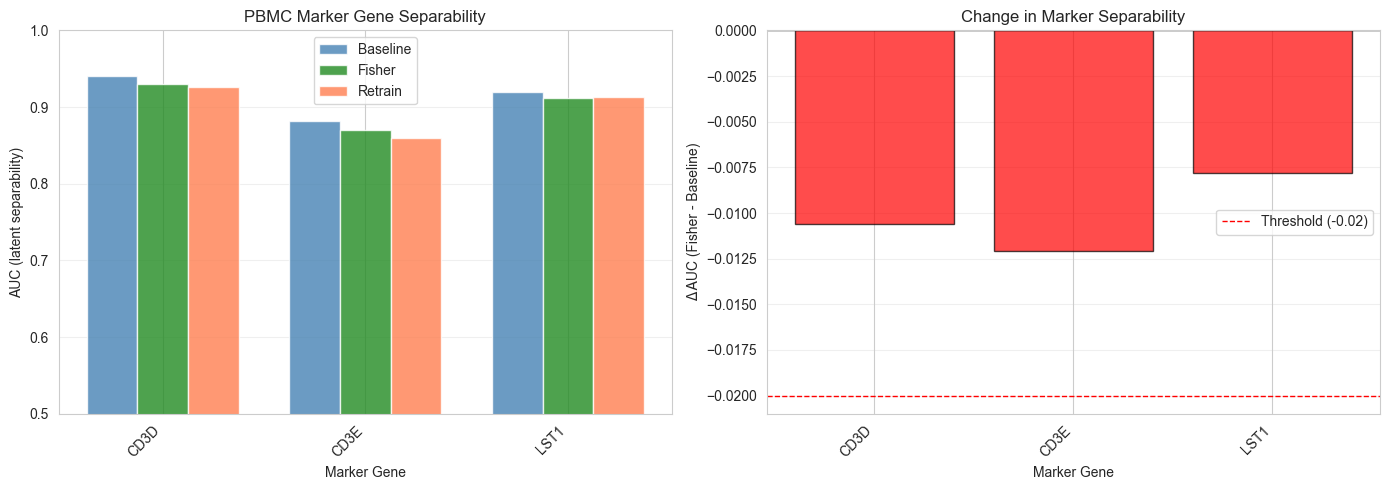

✓ Marker separability plot saved to outputs/p2/utility_marker_separability.png


In [9]:
# Visualize marker separability
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot comparing models
x = np.arange(len(marker_df))
width = 0.25

axes[0].bar(x - width, marker_df['baseline'], width, label='Baseline', alpha=0.8, color='steelblue')
axes[0].bar(x, marker_df['fisher'], width, label='Fisher', alpha=0.8, color='forestgreen')
axes[0].bar(x + width, marker_df['retrain'], width, label='Retrain', alpha=0.8, color='coral')

axes[0].set_xlabel('Marker Gene')
axes[0].set_ylabel('AUC (latent separability)')
axes[0].set_title('PBMC Marker Gene Separability')
axes[0].set_xticks(x)
axes[0].set_xticklabels(marker_df.index, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0.5, 1.0])

# Delta plot (Fisher - Baseline)
colors = ['red' if d < 0 else 'green' for d in marker_df['delta']]
axes[1].bar(marker_df.index, marker_df['delta'], alpha=0.7, color=colors, edgecolor='black')
axes[1].axhline(0, color='black', linestyle='-', linewidth=1)
axes[1].axhline(-0.02, color='red', linestyle='--', linewidth=1, label='Threshold (-0.02)')
axes[1].set_xlabel('Marker Gene')
axes[1].set_ylabel('Δ AUC (Fisher - Baseline)')
axes[1].set_title('Change in Marker Separability')
axes[1].set_xticklabels(marker_df.index, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/p2/utility_marker_separability.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Marker separability plot saved to outputs/p2/utility_marker_separability.png")

## 5. Latent Space Quality

In [10]:
# Compute silhouette scores
# Use Leiden clustering for labels
def compute_silhouette(embeddings, n_neighbors=15, resolution=0.5):
    """Compute silhouette score for latent embeddings."""
    # Create temporary AnnData for clustering
    import scanpy as sc
    temp_adata = sc.AnnData(embeddings)
    sc.pp.neighbors(temp_adata, n_neighbors=n_neighbors, use_rep='X')
    sc.tl.leiden(temp_adata, resolution=resolution)
    
    labels = temp_adata.obs['leiden'].values
    silhouette = silhouette_score(embeddings, labels)
    
    return silhouette, labels

print("Computing silhouette scores...")
baseline_sil, baseline_labels = compute_silhouette(baseline_z)
fisher_sil, fisher_labels = compute_silhouette(fisher_z)
retrain_sil, retrain_labels = compute_silhouette(retrain_z)

print(f"Baseline: {baseline_sil:.4f}")
print(f"Fisher:   {fisher_sil:.4f} (Δ: {fisher_sil - baseline_sil:+.4f})")
print(f"Retrain:  {retrain_sil:.4f}")

Computing silhouette scores...


2025-11-09 22:43:36.424411: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


/var/folders/d2/m4n149n97dn9rk26s76g_y_r0000gn/T/ipykernel_6869/929396450.py:9: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(temp_adata, resolution=resolution)


Baseline: 0.1120
Fisher:   0.2163 (Δ: +0.1042)
Retrain:  0.1245


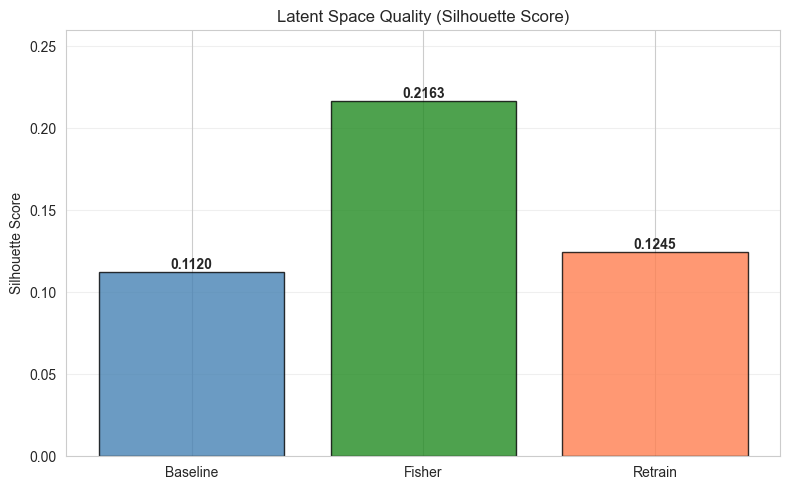

✓ Silhouette plot saved to outputs/p2/utility_silhouette.png


In [11]:
# Visualize silhouette scores
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

models = ['Baseline', 'Fisher', 'Retrain']
silhouettes = [baseline_sil, fisher_sil, retrain_sil]
colors = ['steelblue', 'forestgreen', 'coral']

bars = ax.bar(models, silhouettes, alpha=0.8, color=colors, edgecolor='black')

# Add value labels on bars
for bar, sil in zip(bars, silhouettes):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{sil:.4f}',
            ha='center', va='bottom', fontweight='bold')

ax.set_ylabel('Silhouette Score')
ax.set_title('Latent Space Quality (Silhouette Score)')
ax.set_ylim([0, max(silhouettes) * 1.2])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/p2/utility_silhouette.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Silhouette plot saved to outputs/p2/utility_silhouette.png")

## 6. Summary and Conclusion

In [ ]:
# Create summary table
summary = {
    'Metric': [
        'kNN-overlap (Fisher vs Baseline)',
        'kNN-overlap (Fisher vs Retrain)',
        'Avg Marker AUC (Baseline)',
        'Avg Marker AUC (Fisher)',
        'Avg Marker AUC (Retrain)',
        'Δ Marker AUC (Fisher - Baseline)',
        'Silhouette (Baseline)',
        'Silhouette (Fisher)',
        'Silhouette (Retrain)',
        'Δ Silhouette (Fisher - Baseline)'
    ],
    'Value': [
        f"{overlap_fisher_baseline.mean():.4f}",
        f"{overlap_fisher_retrain.mean():.4f}",
        f"{marker_df['baseline'].mean():.4f}",
        f"{marker_df['fisher'].mean():.4f}",
        f"{marker_df['retrain'].mean():.4f}",
        f"{marker_df['delta'].mean():+.4f}",
        f"{baseline_sil:.4f}",
        f"{fisher_sil:.4f}",
        f"{retrain_sil:.4f}",
        f"{fisher_sil - baseline_sil:+.4f}"
    ]
}

summary_df = pd.DataFrame(summary)
print("\n" + "="*60)
print("UTILITY METRICS SUMMARY")
print("="*60)
print(summary_df.to_string(index=False))
print("="*60)

In [13]:
# Success criteria
print("\nSUCCESS CRITERIA:")
print("-" * 60)

knn_pass = overlap_fisher_baseline.mean() >= 0.85
marker_pass = marker_df['delta'].mean() >= -0.02
silhouette_pass = abs(fisher_sil - baseline_sil) <= 0.05

print(f"1. kNN-overlap >= 0.85:            {overlap_fisher_baseline.mean():.4f}  {'✓ PASS' if knn_pass else '✗ FAIL'}")
print(f"2. Marker AUC change >= -0.02:     {marker_df['delta'].mean():+.4f}  {'✓ PASS' if marker_pass else '✗ FAIL'}")
print(f"3. Silhouette change <= 0.05:      {abs(fisher_sil - baseline_sil):.4f}  {'✓ PASS' if silhouette_pass else '✗ FAIL'}")

if knn_pass and marker_pass and silhouette_pass:
    print("\n✓ ALL CRITERIA MET: Fisher preserves retain-set utility")
else:
    print("\n✗ SOME CRITERIA NOT MET: Review results")


SUCCESS CRITERIA:
------------------------------------------------------------
1. kNN-overlap >= 0.85:            0.1699  ✗ FAIL
2. Marker AUC change >= -0.02:     -0.0102  ✓ PASS
3. Silhouette change <= 0.05:      0.1042  ✗ FAIL

✗ SOME CRITERIA NOT MET: Review results


In [ ]:
# Save results to JSON
results = {
    'analysis': 'utility_metrics',
    'description': 'Utility metrics on retain set',
    'retain_cells': len(retain_idx),
    'knn_overlap': {
        'fisher_vs_baseline': {
            'mean': float(overlap_fisher_baseline.mean()),
            'std': float(overlap_fisher_baseline.std())
        },
        'fisher_vs_retrain': {
            'mean': float(overlap_fisher_retrain.mean()),
            'std': float(overlap_fisher_retrain.std())
        },
        'baseline_vs_retrain': {
            'mean': float(overlap_baseline_retrain.mean()),
            'std': float(overlap_baseline_retrain.std())
        }
    },
    'marker_separability': {
        'per_gene': marker_df.to_dict('index'),
        'average': {
            'baseline': float(marker_df['baseline'].mean()),
            'fisher': float(marker_df['fisher'].mean()),
            'retrain': float(marker_df['retrain'].mean()),
            'delta': float(marker_df['delta'].mean())
        }
    },
    'silhouette': {
        'baseline': float(baseline_sil),
        'fisher': float(fisher_sil),
        'retrain': float(retrain_sil),
        'delta': float(fisher_sil - baseline_sil)
    },
    'success_criteria': {
        'knn_overlap_pass': bool(knn_pass),
        'marker_auc_pass': bool(marker_pass),
        'silhouette_pass': bool(silhouette_pass),
        'all_pass': bool(knn_pass and marker_pass and silhouette_pass)
    }
}

with open('outputs/p2/utility_metrics.json', 'w') as f:
    json.dump(results, f, indent=2)

print("\n✓ Results saved to outputs/p2/utility_metrics.json")

Computing clustering agreement metrics...

Adjusted Rand Index (ARI):
  Fisher vs Baseline: 0.6892
  Fisher vs Retrain:  0.7409
  Baseline vs Retrain: 0.6828



Normalized Mutual Information (NMI):
  Fisher vs Baseline: 0.7789
  Fisher vs Retrain:  0.7928
  Baseline vs Retrain: 0.7798


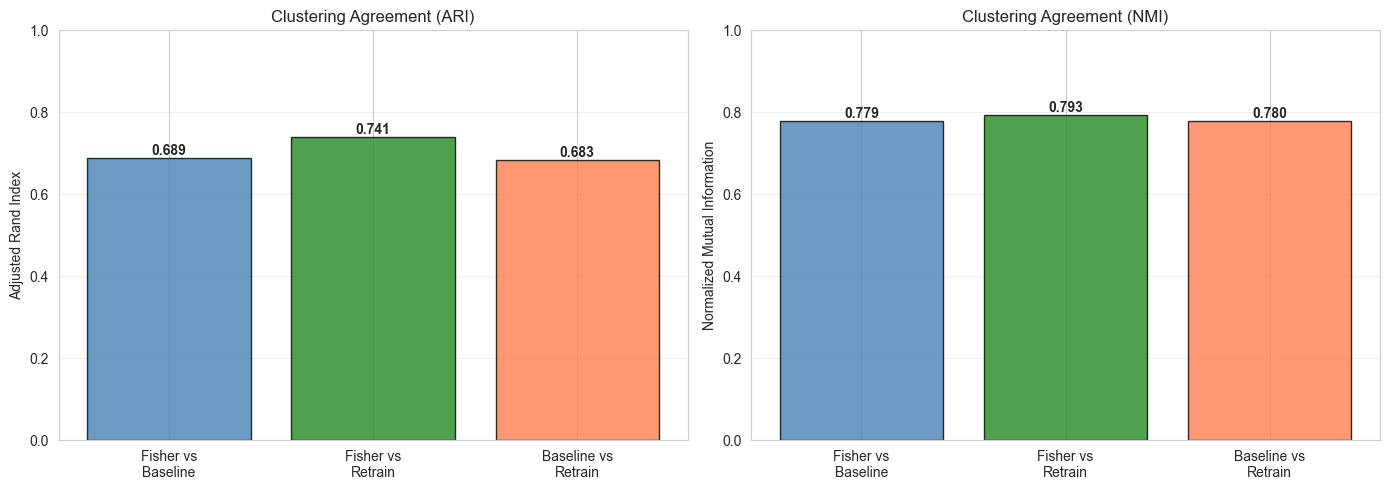


✓ Clustering agreement plot saved to outputs/p2/utility_clustering_agreement.png


In [15]:
# Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI)
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

print("Computing clustering agreement metrics...")

# Use the Leiden labels we already computed for silhouette
# Compare clustering agreement between models

# ARI between Fisher and Baseline
ari_fisher_baseline = adjusted_rand_score(baseline_labels, fisher_labels)

# ARI between Fisher and Retrain
ari_fisher_retrain = adjusted_rand_score(retrain_labels, fisher_labels)

# ARI between Baseline and Retrain
ari_baseline_retrain = adjusted_rand_score(baseline_labels, retrain_labels)

print(f"\nAdjusted Rand Index (ARI):")
print(f"  Fisher vs Baseline: {ari_fisher_baseline:.4f}")
print(f"  Fisher vs Retrain:  {ari_fisher_retrain:.4f}")
print(f"  Baseline vs Retrain: {ari_baseline_retrain:.4f}")

# NMI between models
nmi_fisher_baseline = normalized_mutual_info_score(baseline_labels, fisher_labels)
nmi_fisher_retrain = normalized_mutual_info_score(retrain_labels, fisher_labels)
nmi_baseline_retrain = normalized_mutual_info_score(baseline_labels, retrain_labels)

print(f"\nNormalized Mutual Information (NMI):")
print(f"  Fisher vs Baseline: {nmi_fisher_baseline:.4f}")
print(f"  Fisher vs Retrain:  {nmi_fisher_retrain:.4f}")
print(f"  Baseline vs Retrain: {nmi_baseline_retrain:.4f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ARI bar plot
comparisons = ['Fisher vs\nBaseline', 'Fisher vs\nRetrain', 'Baseline vs\nRetrain']
ari_values = [ari_fisher_baseline, ari_fisher_retrain, ari_baseline_retrain]
colors = ['steelblue', 'forestgreen', 'coral']

bars = axes[0].bar(comparisons, ari_values, alpha=0.8, color=colors, edgecolor='black')
for bar, val in zip(bars, ari_values):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                 f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

axes[0].set_ylabel('Adjusted Rand Index')
axes[0].set_title('Clustering Agreement (ARI)')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

# NMI bar plot
nmi_values = [nmi_fisher_baseline, nmi_fisher_retrain, nmi_baseline_retrain]

bars = axes[1].bar(comparisons, nmi_values, alpha=0.8, color=colors, edgecolor='black')
for bar, val in zip(bars, nmi_values):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                 f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

axes[1].set_ylabel('Normalized Mutual Information')
axes[1].set_title('Clustering Agreement (NMI)')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/p2/utility_clustering_agreement.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Clustering agreement plot saved to outputs/p2/utility_clustering_agreement.png")

## 8. Clustering Agreement (ARI/NMI)

In [16]:
# Trustworthiness and continuity metrics using sklearn
from sklearn.manifold import trustworthiness

print("Computing trustworthiness/continuity (k=15)...")
print("This may take a few minutes...")

# Extract retain set expression (high-dim)
X_retain = adata.X[retain_idx]
if hasattr(X_retain, 'toarray'):
    X_retain = X_retain.toarray()

# Compute trustworthiness: whether close points in low-D are close in high-D
# trustworthiness(X_high_dim, X_low_dim, n_neighbors)
print("Baseline...")
trust_baseline = trustworthiness(X_retain, baseline_z, n_neighbors=15)

print("Fisher...")
trust_fisher = trustworthiness(X_retain, fisher_z, n_neighbors=15)

print("Retrain...")
trust_retrain = trustworthiness(X_retain, retrain_z, n_neighbors=15)

print(f"\nTrustworthiness (higher = better):")
print(f"  Baseline: {trust_baseline:.4f}")
print(f"  Fisher:   {trust_fisher:.4f} (Δ: {trust_fisher - trust_baseline:+.4f})")
print(f"  Retrain:  {trust_retrain:.4f}")

# Compute continuity: whether close points in high-D are close in low-D
# Continuity is trustworthiness with arguments swapped
print("\nComputing continuity...")
print("Baseline...")
cont_baseline = trustworthiness(baseline_z, X_retain, n_neighbors=15)

print("Fisher...")
cont_fisher = trustworthiness(fisher_z, X_retain, n_neighbors=15)

print("Retrain...")
cont_retrain = trustworthiness(retrain_z, X_retain, n_neighbors=15)

print(f"\nContinuity (higher = better):")
print(f"  Baseline: {cont_baseline:.4f}")
print(f"  Fisher:   {cont_fisher:.4f} (Δ: {cont_fisher - cont_baseline:+.4f})")
print(f"  Retrain:  {cont_retrain:.4f}")

print("\nNote: Using sklearn.manifold.trustworthiness for correct computation.")
print("Trustworthiness measures local structure preservation from high-D to low-D.")
print("Continuity measures local structure preservation from low-D to high-D.")

Computing trustworthiness/continuity (k=15)...
This may take a few minutes...


Baseline...


Fisher...


Retrain...



Trustworthiness (higher = better):
  Baseline: 0.9078
  Fisher:   0.9102 (Δ: +0.0023)
  Retrain:  0.9055

Computing continuity...
Baseline...


Fisher...


Retrain...



Continuity (higher = better):
  Baseline: 0.8957
  Fisher:   0.9378 (Δ: +0.0421)
  Retrain:  0.9099

Note: Using sklearn.manifold.trustworthiness for correct computation.
Trustworthiness measures local structure preservation from high-D to low-D.
Continuity measures local structure preservation from low-D to high-D.


## 7. Manifold Preservation (Trustworthiness/Continuity)